In [2]:
import pandas as pd
from pathlib import Path
import os

setup: train_test split, undersampling

In [3]:
directory = Path(os.getcwd())   # 'c:\\Users\\samue\\OneDrive\\Desktop\\JPM Fintech\\HKUST-x-J.P.-Morgan-Fintech-Mentorship-Program\\model_testing\\supervised'
directory = directory.parent.parent.parent.joinpath("data")  # 'c:\\Users\\samue\\OneDrive\\Desktop\\JPM Fintech\\data'
df = pd.read_pickle(directory.joinpath("stocktwits_processed_without_multiple_sample.pkl"))
df

,text,time,symbols
0,pullback today,1639642896,$AAPL
1,look! The teddy bear picnic is starting! Lol,1639642665,$AAPL
2,,1639642565,$AAPL
3,classic inflation of calls in order to load u...,1639641515,$AAPL
4,"Guys, AAPL consolidating well and ready to go...",1639641435,$AAPL
...,...,...,...
36276,great day 👍👍,1640153385,$V
36277,inverse head n shoulders.... 222 possible tom...,1640149580,$V
36278,[15s. delayed]: Issued Press Release on Decem...,1640148346,$V
36279,damn putting in some work last couple of weeks..,1640139998,$V


In [5]:
def setup(sample=1000, ratio=0.8, is_token=True, sample_method=0):
    # set directory
    directory = Path(os.getcwd())   # 'c:\\Users\\samue\\OneDrive\\Desktop\\JPM Fintech\\HKUST-x-J.P.-Morgan-Fintech-Mentorship-Program\\model_testing\\supervised'
    directory = directory.parent.parent.parent.joinpath("data")  # 'c:\\Users\\samue\\OneDrive\\Desktop\\JPM Fintech\\data'
    df = pd.read_pickle(directory.joinpath("stocktwits_processed_without_multiple_sample.pkl"))
    
    # remove symbols with too little sample size
    df = df.groupby('symbols').filter(lambda x : len(x)>sample)

    if sample_method == 0:
        # turn all symbols into the same sample size
        i = sample
        for j in set(df['symbols']):
            df = df[df['symbols'] != j].append(df[df['symbols'] == j].sample(i), ignore_index=True)
        #print(df['symbols'].value_counts())
    
    # train_test split
    df_train = df.sample(frac=ratio,random_state=200)
    df_test = df.drop(df_train.index)

    if is_token:
        X_train = df_train.tokens
        X_test = df_test.tokens
    else:
        X_train = df_train.text
        X_test = df_test.text
        
    y_train = df_train.symbols
    y_test = df_test.symbols

    print_str = "{} unique classes\t{} training samples\t{} test samples".format(len(set(y_train)), len(X_train), len(X_test))

    return X_train, X_test, y_train, y_test, print_str

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import NearMiss
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import GridSearchCV

@ignore_warnings(category=ConvergenceWarning)
def model(X_train, X_test, y_train, y_test, model_method, sample_method):
    # Build the model
    model = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer())])

    if sample_method == 1:
        model.steps.append(['smote', SMOTE(random_state=12)])
    elif sample_method == 2:
        model.steps.append(['nm', NearMiss()])

    if model_method == 0:
        model.steps.append(['clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)])
        #model.steps.append(['clf', SVC()])
        #param_grid = {'clf__C': [0.1, 1, 10, 100, 1000],
              #'clf__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              #'clf__kernel': ['rbf', 'linear','polynomial']}

    elif model_method == 1:
        model.steps.append(['clf', MultinomialNB()])
        #param_grid = {
  #'clf__alpha': np.linspace(0.5, 1.5, 6),
  #'clf__fit_prior': [True, False], }
  
    elif model_method == 2:
        model.steps.append(['clf', LogisticRegression(n_jobs=1, C=1e5)])

    #model = GridSearchCV(model, param_grid, n_jobs=2)
    #print(model)
    # Train the model using the training data
    model.fit(X_train, y_train)
    # Predict the symbols of the test data
    y_pred = model.predict(X_test)
    # accuracy
    #print("The accuracy is {}".format(accuracy_score(y_test, y_pred)))
    
    # plot the confusion matrix
    mat = confusion_matrix(y_test, y_pred)
    #sns.heatmap(mat.T, square = True, annot=True, fmt = "d", xticklabels=set(y_train),yticklabels=set(y_train))
    #plt.xlabel("true labels")
    #plt.ylabel("predicted label")
    #plt.show()

    return accuracy_score(y_test, y_pred), classification_report(y_test, y_pred,target_names=set(y_train)), mat

Method 1: random sample

In [9]:
iteration = 10

model_no = 0

for s in [290,500,1000]:
    for r in [0.7]:
        for t in [False]:
            for i in range(0, 3):
                print('sample:{}\tratio:{}\ttoken:{}'.format(s,r,t))
        
                scores = []
                for j in range(iteration):
                    X_train, X_test, y_train, y_test, print_str = setup(s, r, t, model_no)
                    if j == 0:
                        print(print_str)
                    score,a,b = model(X_train, X_test, y_train, y_test, i, model_no)
                    scores.append(score)
                print('{}: {}'.format(i, sum(scores)/len(scores)))
                print()

sample:290	ratio:0.7	token:False
12 unique classes	2436 training samples	1044 test samples
0: 0.471455938697318

sample:290	ratio:0.7	token:False
12 unique classes	2436 training samples	1044 test samples
1: 0.3977011494252874

sample:290	ratio:0.7	token:False
12 unique classes	2436 training samples	1044 test samples
2: 0.4523946360153256

sample:500	ratio:0.7	token:False
10 unique classes	3500 training samples	1500 test samples
0: 0.4945333333333333

sample:500	ratio:0.7	token:False
10 unique classes	3500 training samples	1500 test samples
1: 0.43273333333333336

sample:500	ratio:0.7	token:False
10 unique classes	3500 training samples	1500 test samples
2: 0.47859999999999997

sample:1000	ratio:0.7	token:False
5 unique classes	3500 training samples	1500 test samples
0: 0.4905333333333332

sample:1000	ratio:0.7	token:False
5 unique classes	3500 training samples	1500 test samples
1: 0.46419999999999995

sample:1000	ratio:0.7	token:False
5 unique classes	3500 training samples	1500 test sam

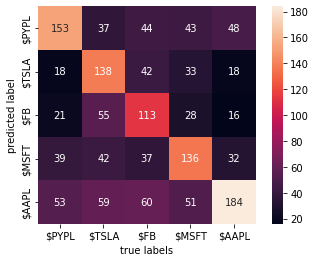

In [8]:
sns.heatmap(b.T, square = True, annot=True, fmt = "d", xticklabels=set(y_train),yticklabels=set(y_train))
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

Method 2: with SMOTE

In [18]:
iteration = 10

for s in [500,1000]:
    for r in [0.7]:
        for t in [True]:
            print('sample:{}\tratio:{}\ttoken:{}'.format(s,r,t))
    
            scores = []
            for i in range(iteration):
                X_train, X_test, y_train, y_test, print_str = setup(s, r, t, 1)
                if i == 0:
                    print(print_str)
                score = model(X_train, X_test, y_train, y_test, 0, 1)[0]
                scores.append(score)
            print('SVM: {}'.format(sum(scores)/len(scores)))
            print()
        

            scores = []
            for i in range(iteration):
                X_train, X_test, y_train, y_test, print_str = setup(s, r, t, 1)
                if i == 0:
                    print(print_str)
                score = model(X_train, X_test, y_train, y_test, 1, 1)[0]
                scores.append(score)
            print('NB: {}'.format(sum(scores)/len(scores)))
            print()

        
            scores = []
            for i in range(iteration):
                X_train, X_test, y_train, y_test, print_str = setup(s, r, t, 1)
                if i == 0:
                    print(print_str)
                score = model(X_train, X_test, y_train, y_test, 2, 1)[0]
                scores.append(score)
            print('logreg: {}'.format(sum(scores)/len(scores)))
        
            print()

sample:500	ratio:0.7	token:True
18 unique classes	42809 training samples	18347 test samples
SVM: 0.3265383986482804

18 unique classes	42809 training samples	18347 test samples
NB: 0.3506295307134682

18 unique classes	42809 training samples	18347 test samples
logreg: 0.34561508693519377

sample:1000	ratio:0.7	token:True
12 unique classes	39831 training samples	17071 test samples
SVM: 0.38656200574072985

12 unique classes	39831 training samples	17071 test samples
NB: 0.39470446956827365

12 unique classes	39831 training samples	17071 test samples
logreg: 0.38257864214164367



Method 2: NearMiss

In [21]:
iteration = 10

for s in [500,1000]:
    for r in [0.7]:
        for t in [True]:
            print('sample:{}\tratio:{}\ttoken:{}'.format(s,r,t))
    
            scores = []
            for i in range(iteration):
                X_train, X_test, y_train, y_test, print_str = setup(s, r, t, 2)
                if i == 0:
                    print(print_str)
                score = model(X_train, X_test, y_train, y_test, 0, 2)[0]
                scores.append(score)
            print('SVM: {}'.format(sum(scores)/len(scores)))
            print()
        

            scores = []
            for i in range(iteration):
                X_train, X_test, y_train, y_test, print_str = setup(s, r, t, 2)
                if i == 0:
                    print(print_str)
                score = model(X_train, X_test, y_train, y_test, 1, 2)[0]
                scores.append(score)
            print('NB: {}'.format(sum(scores)/len(scores)))
            print()

        
            scores = []
            for i in range(iteration):
                X_train, X_test, y_train, y_test, print_str = setup(s, r, t, 2)
                if i == 0:
                    print(print_str)
                score = model(X_train, X_test, y_train, y_test, 2, 2)[0]
                scores.append(score)
            print('logreg: {}'.format(sum(scores)/len(scores)))
        
            print()

sample:500	ratio:0.7	token:True
18 unique classes	42809 training samples	18347 test samples
SVM: 0.08758925164877093

18 unique classes	42809 training samples	18347 test samples
NB: 0.08682618411729438

18 unique classes	42809 training samples	18347 test samples


KeyboardInterrupt: 